In [ ]:
%pip install boruta
%pip install imblearn
%pip install shap
%pip install optuna
%pip install optuna-integration[sklearn]

!pip install lightgbm
!pip install --upgrade imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import time
import lightgbm as lgb
import psutil
import shap
import gc  # Garbage collector untuk clear memory
import optuna
from optuna.integration import OptunaSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from boruta import BorutaPy

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**BAGIAN 1: PREPROCESSING DATA**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/merged_dataset_saya_setelah_rename.csv')

Cleaning Data

In [ ]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # hanya tampilkan kolom yang ada null-nya

Std         25
Variance    25
dtype: int64


In [ ]:
df = df.dropna() #Hapus 25 baris

Cleaning Infinity & NaN

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)

for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        if pd.isna(median_val):
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna(median_val, inplace=True)

Cek Duplicate Value

In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Jumlah baris duplikat: {num_duplicates}")

Jumlah baris duplikat: 83381


In [ ]:
# Hapus semua baris yang identik/duplikat
df = df.drop_duplicates()

# Cek kembali bentuk data
print(f"Jumlah data setelah hapus duplikat: {df.shape}")

Jumlah data setelah hapus duplikat: (744252, 41)


Memisahkan Fitur & Label

In [ ]:
X = df.drop(["label", "category"], axis=1)
y = df["label"]

Label Encoding

In [ ]:
#Inisialisasi Encoder
le = LabelEncoder()

# Fit dan transform label
df['Label_encoded'] = le.fit_transform(df['label'])

In [ ]:
# Display the first few rows of the dataframe with the new column
display(df.head())

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label,Label_encoded
0,0.24,47,64.00,3988.838908,0.0,0.00,0.0,0.0,0.00,0.0,...,578,563.26,84.239991,563.26,0.000251,100,7096.376162,Mirai,Mirai_Greip_Flood,24
1,0.00,47,64.00,5156.508483,0.0,0.00,0.0,0.0,0.00,0.0,...,578,573.20,48.000000,573.20,0.000195,100,2304.000000,Mirai,Mirai_Greip_Flood,24
2,0.00,47,64.00,2756.635755,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578.00,0.000000,578.00,0.000363,100,0.000000,Mirai,Mirai_Greip_Flood,24
3,0.00,47,64.00,13734.704303,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578.00,0.000000,578.00,0.000074,100,0.000000,Mirai,Mirai_Greip_Flood,24
4,0.64,47,65.79,2448.342206,0.0,0.01,0.0,0.0,0.01,0.0,...,590,563.09,75.596763,563.09,0.000408,100,5714.870606,Mirai,Mirai_Greip_Flood,24


In [ ]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Label -> Angka:")
for label, encoded in label_mapping.items():
    print(f"{label} -> {encoded}")

Mapping Label -> Angka:
Backdoor_Malware -> 0
Benign_Traffic -> 1
Browser_Hijacking -> 2
Command_Injection -> 3
DDoS_ACK_Fragmentation -> 4
DDoS_HTTP_Flood -> 5
DDoS_ICMP_Flood -> 6
DDoS_ICMP_Fragmentation -> 7
DDoS_PSHACK_Flood -> 8
DDoS_RSTFIN_Flood -> 9
DDoS_SYN_Flood -> 10
DDoS_SlowLoris -> 11
DDoS_SynonymousIP_Flood -> 12
DDoS_TCP_Flood -> 13
DDoS_UDP_Flood -> 14
DDoS_UDP_Fragmentation -> 15
DNS_Spoofing -> 16
Dictionary_Brute_Force -> 17
DoS_HTTP_Flood -> 18
DoS_SYN_Flood -> 19
DoS_TCP_Flood -> 20
DoS_UDP_Flood -> 21
MITM_Arp_Spoofing -> 22
Mirai_Greeth_Flood -> 23
Mirai_Greip_Flood -> 24
Mirai_UDPPlain -> 25
Recon_Host_Discovery -> 26
Recon_OSScan -> 27
Recon_Ping_Sweep -> 28
Recon_Port_Scan -> 29
Recon_Vulnerability_Scan -> 30
SQL_Injection -> 31
Uploading_Attack -> 32
XSS -> 33


Split Data

In [ ]:
# Split 1: Train vs (Val+Test) - 70% vs 30%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,      # 30% untuk val+test
    stratify=y,         # Stratified untuk jaga proporsi kelas dan PENTING untuk imbalanced data
    random_state=42
)

# Split 2: Val vs Test - 15% vs 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # 50% dari 30% = 15% dari total
    stratify=y_temp,
    random_state=42
)

print(f" Data split complete!")
print(f"   Train: {X_train.shape[0]:,} samples")
print(f"   Val:   {X_val.shape[0]:,} samples")
print(f"   Test:  {X_test.shape[0]:,} samples")

 Data split complete!
   Train: 520,976 samples
   Val:   111,638 samples
   Test:  111,638 samples


Seleksi Fitur Tahap Awal

In [ ]:
# Cek fitur dengan 1 nilai unik
constant_columns = [col for col in X_train.columns if X_train[col].nunique() == 1]
print("Fitur konstan:", constant_columns)

Fitur konstan: []


In [ ]:
# Hapus jika ada dari semua set data
if constant_columns:
    X_train.drop(columns=constant_columns, inplace=True)
    print(f"Fitur konstan {constant_columns} dihapus dari X_train_res.")
else:
    print("Tidak ada fitur konstan yang ditemukan.")

Tidak ada fitur konstan yang ditemukan.


In [ ]:
# Hitung korelasi
corr_matrix = X_train.corr().abs()

# Ambil korelasi di atas threshold (misal 0.98)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

print("Fitur berkorelasi tinggi:", to_drop)

Fitur berkorelasi tinggi: ['fin_count', 'IPv', 'LLC', 'Tot size']


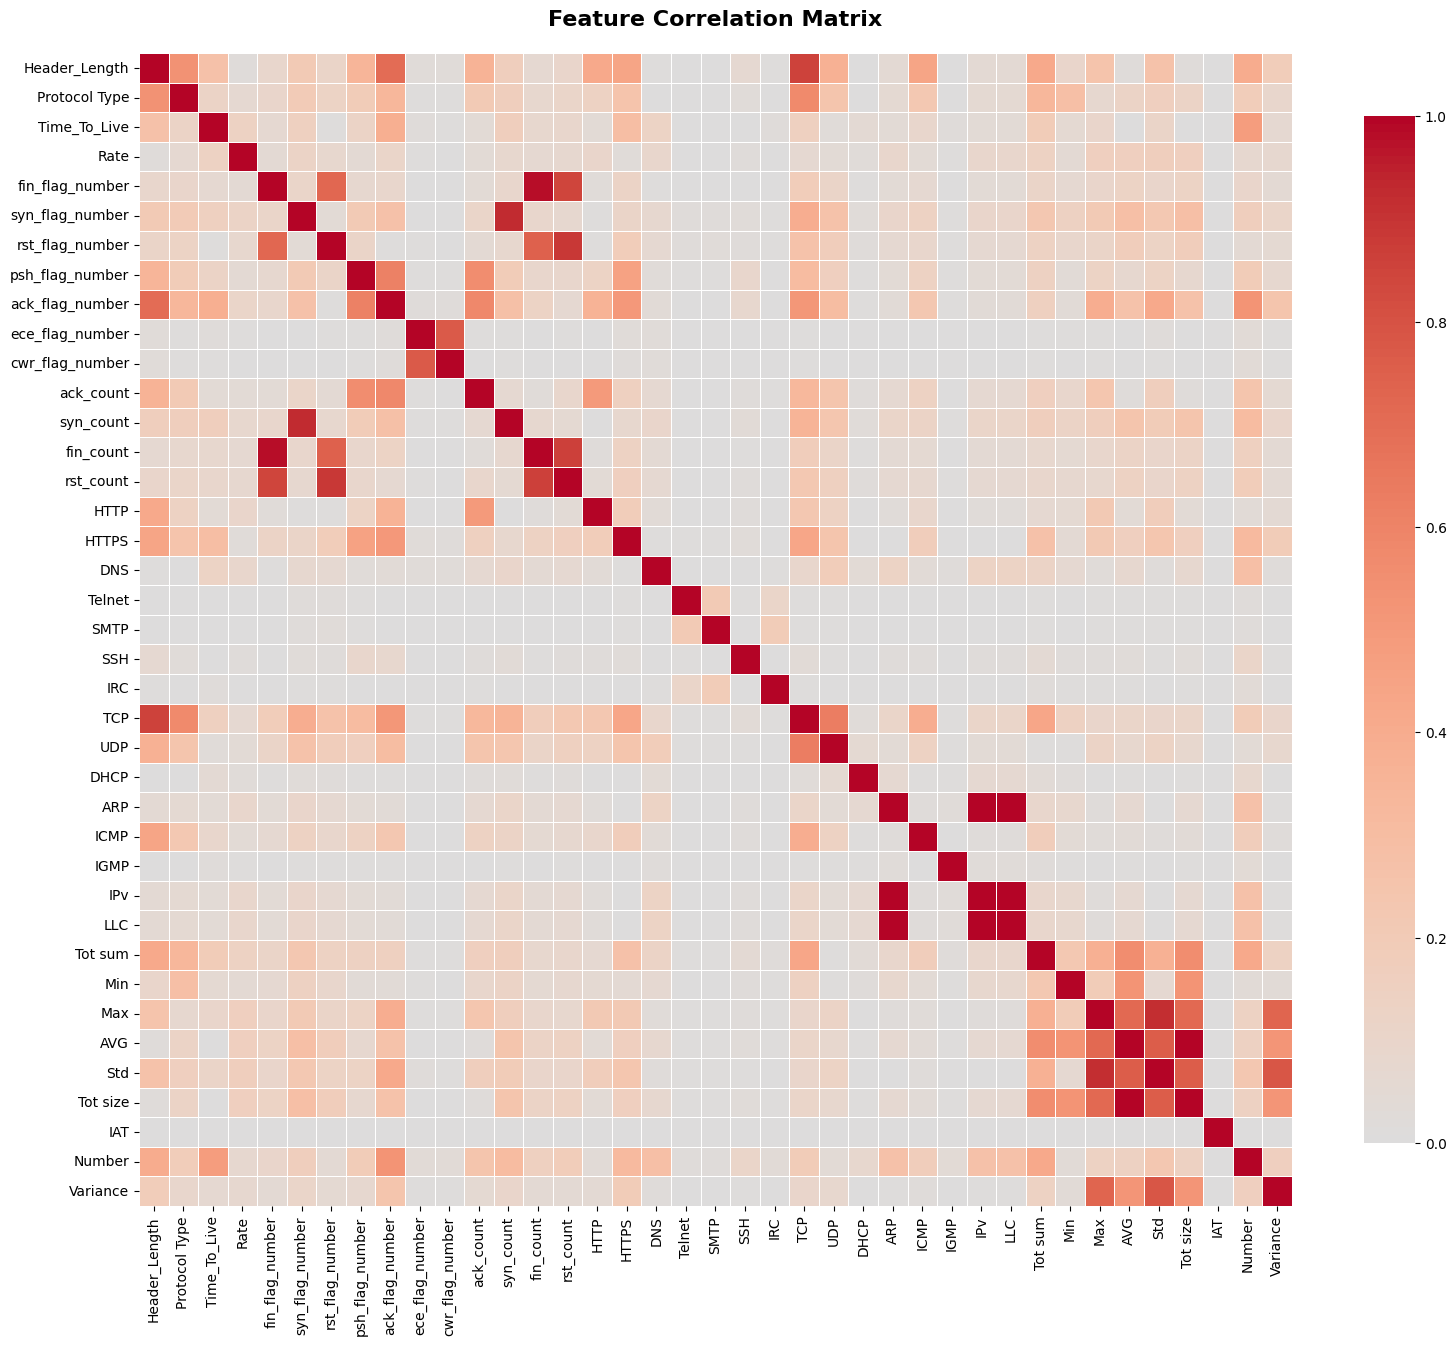

In [ ]:
# Visualisasi Heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=False,  # Set True jika fitur sedikit (<20)
    cmap='coolwarm',
    center=0,
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Find High Correlation Pairs
def find_high_correlation_pairs(corr_matrix, threshold=0.95):
    """
    Menemukan pasangan fitur dengan korelasi tinggi
    """
    # Ambil upper triangle (avoid duplicates)
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Find pairs above threshold
    high_corr_pairs = []

    for column in upper_tri.columns:
        high_corr_features = upper_tri[column][upper_tri[column] > threshold]

        for feature, corr_value in high_corr_features.items():
            high_corr_pairs.append({
                'Feature_1': column,
                'Feature_2': feature,
                'Correlation': corr_value
            })

    # Convert to DataFrame and sort
    df_pairs = pd.DataFrame(high_corr_pairs).sort_values(
        'Correlation', ascending=False
    )

    return df_pairs

In [ ]:
# Cari pasangan dengan korelasi > 0.95
threshold = 0.95
high_corr_df = find_high_correlation_pairs(corr_matrix, threshold)

print(f"HIGH CORRELATION PAIRS (threshold > {threshold})")

if len(high_corr_df) > 0:
    print(f"\n Found {len(high_corr_df)} pairs with correlation > {threshold}:\n")
    print(high_corr_df.to_string(index=False))

    # Summary statistics
    print(f"\n Correlation Statistics:")
    print(f"   Highest correlation: {high_corr_df['Correlation'].max():.4f}")
    print(f"   Average correlation: {high_corr_df['Correlation'].mean():.4f}")
    print(f"   Lowest (above threshold): {high_corr_df['Correlation'].min():.4f}")
else:
    print(f"\n No pairs found with correlation > {threshold}")

HIGH CORRELATION PAIRS (threshold > 0.95)

 Found 5 pairs with correlation > 0.95:

Feature_1       Feature_2  Correlation
      IPv             ARP     1.000000
      LLC             ARP     1.000000
      LLC             IPv     1.000000
 Tot size             AVG     1.000000
fin_count fin_flag_number     0.981969

 Correlation Statistics:
   Highest correlation: 1.0000
   Average correlation: 0.9964
   Lowest (above threshold): 0.9820


In [ ]:
print(f" Menghapus {len(to_drop)} Fitur Mirip/Korelasi Tinggi")

X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

 Menghapus 4 Fitur Mirip/Korelasi Tinggi


In [ ]:
if to_drop:
    print(f" Dropped {len(to_drop)} features")
    print(f" Remaining features: {X_train.shape[1]}")
else:
    print("\n No highly correlated features found")

 Dropped 4 features
 Remaining features: 35


Cleaning infinity & NaN Lagi

In [ ]:
print("Final cleaning before Boruta...")
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

for col in X_train.columns:
    if X_train[col].isnull().any():
        median_val = X_train[col].median()
        if pd.isna(median_val):
            X_train[col].fillna(0, inplace=True)
            X_val[col].fillna(0, inplace=True)
            X_test[col].fillna(0, inplace=True)
        else:
            X_train[col].fillna(median_val, inplace=True)
            X_val[col].fillna(median_val, inplace=True)
            X_test[col].fillna(median_val, inplace=True)

Final cleaning before Boruta...


In [ ]:
# Verify data is clean
print(" Verification:")
print(f"   Train - Inf: {np.isinf(X_train.values).any()}, NaN: {X_train.isnull().values.any()}")
print(f"   Val   - Inf: {np.isinf(X_val.values).any()}, NaN: {X_val.isnull().values.any()}")
print(f"   Test  - Inf: {np.isinf(X_test.values).any()}, NaN: {X_test.isnull().values.any()}")

 Verification:
   Train - Inf: False, NaN: False
   Val   - Inf: False, NaN: False
   Test  - Inf: False, NaN: False


Seleksi Fitur dengan Boruta

In [ ]:
# Random Forest dengan parameter balanced
rf = RandomForestClassifier(
    n_estimators=100,      # Cukup untuk stability
    max_depth=15,          # Cukup dalam untuk 34 kelas
    min_samples_split=10,  # Prevent overfitting
    min_samples_leaf=4,    # Prevent overfitting
    max_features='sqrt',   # Good default untuk classification
    class_weight='balanced',  # Penting untuk imbalanced
    n_jobs=-1,             # Use all cores
    random_state=42,
    bootstrap=True,
    oob_score=False,       # Save memory
    verbose=0
)

In [ ]:
# Boruta dengan parameter optimal
boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',   # Auto-determine iterations
    max_iter=100,          # Maximum iterations
    verbose=2,             # Show progress
    random_state=42,
    perc=100,              # Percentile for importance threshold
    alpha=0.05             # Statistical significance level
)

In [ ]:
    print(f" Dataset Info:")
    print(f"   Samples: {X_train.shape[0]:,}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Classes: {len(np.unique(y_train))}")

    print(f"\n Random Forest Config:")
    print(f"   n_estimators: {rf.n_estimators}")
    print(f"   max_depth: {rf.max_depth}")
    print(f"   max_features: {rf.max_features}")
    print(f"   class_weight: {rf.class_weight}")

    print(f"\n Boruta Config:")
    print(f"   max_iter: {boruta.max_iter}")
    print(f"   alpha: {boruta.alpha}")

 Dataset Info:
   Samples: 520,976
   Features: 35
   Classes: 34

 Random Forest Config:
   n_estimators: 100
   max_depth: 15
   max_features: sqrt
   class_weight: balanced

 Boruta Config:
   max_iter: 100
   alpha: 0.05


In [ ]:
# Fit Boruta Hanya di Train Set
start_time = time.time()

boruta.fit(X_train.values if isinstance(X_train, pd.DataFrame) else X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n Boruta completed in {elapsed_time/60:.1f} minutes")

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	28
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	28
Tentative: 	0
Rejected: 	7

 Boruta completed in 11.8 minutes


In [ ]:
#Simpan hasil Boruta
joblib.dump(boruta, "/content/drive/MyDrive/Dataset/Percobaan_Lima/boruta_model.pkl")

#Simpan daftar fitur terpilih
np.save("/content/drive/MyDrive/Dataset/Percobaan_Lima/selected_features.npy", selected_features)

In [ ]:
#Load hasil Boruta
boruta = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/boruta_model.pkl")

#Load daftar fitur terpilih
selected_features = np.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/selected_features.npy", allow_pickle=True).tolist()

print("Model Boruta dan fitur terpilih berhasil di-load kembali.")
print("Fitur terpilih:", selected_features)

Model Boruta dan fitur terpilih berhasil di-load kembali.
Fitur terpilih: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'UDP', 'ARP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


In [ ]:
# Mendapatkan Fitur Terpilih Boruta
selected_features = X_train.columns[boruta.support_].tolist() if isinstance(X_train, pd.DataFrame) else boruta.support_
rejected_features = X_train.columns[~boruta.support_].tolist() if isinstance(X_train, pd.DataFrame) else ~boruta.support_

print(f" Results:")
print(f"   Selected features: {len(selected_features) if isinstance(selected_features, list) else selected_features.sum()}")
print(f"   Rejected features: {len(rejected_features) if isinstance(rejected_features, list) else rejected_features.sum()}")
print(f"   Selection rate: {100 * boruta.support_.sum() / len(boruta.support_):.1f}%")

 Results:
   Selected features: 28
   Rejected features: 7
   Selection rate: 80.0%


In [ ]:
print(f" SELECTED FEATURES ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n REJECTED FEATURES ({len(rejected_features)}):")
for i, feat in enumerate(rejected_features, 1):
    print(f"   {i:2d}. {feat}")

 SELECTED FEATURES (28):
    1. Header_Length
    2. Protocol Type
    3. Time_To_Live
    4. Rate
    5. fin_flag_number
    6. syn_flag_number
    7. rst_flag_number
    8. psh_flag_number
    9. ack_flag_number
   10. ack_count
   11. syn_count
   12. rst_count
   13. HTTP
   14. HTTPS
   15. DNS
   16. SSH
   17. TCP
   18. UDP
   19. ARP
   20. ICMP
   21. Tot sum
   22. Min
   23. Max
   24. AVG
   25. Std
   26. IAT
   27. Number
   28. Variance

 REJECTED FEATURES (7):
    1. ece_flag_number
    2. cwr_flag_number
    3. Telnet
    4. SMTP
    5. IRC
    6. DHCP
    7. IGMP


In [ ]:
# Lihat ranking semua fitur
print("FEATURE RANKING:")
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': boruta.support_,
    'Ranking': boruta.ranking_
}).sort_values('Ranking')

print(feature_ranking.to_string(index=False))

FEATURE RANKING:
        Feature  Selected  Ranking
  Header_Length      True        1
  Protocol Type      True        1
   Time_To_Live      True        1
           Rate      True        1
fin_flag_number      True        1
syn_flag_number      True        1
rst_flag_number      True        1
psh_flag_number      True        1
ack_flag_number      True        1
      ack_count      True        1
      rst_count      True        1
      syn_count      True        1
           HTTP      True        1
          HTTPS      True        1
            SSH      True        1
            DNS      True        1
            AVG      True        1
            Max      True        1
            UDP      True        1
            TCP      True        1
            Min      True        1
        Tot sum      True        1
           ICMP      True        1
            ARP      True        1
            Std      True        1
       Variance      True        1
         Number      True        1
   

In [ ]:
print(f" Before selection:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

 Before selection:
   X_train: (520976, 35)
   X_val:   (111638, 35)
   X_test:  (111638, 35)


In [ ]:
# Apply ke semua set
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

In [ ]:
print(f" After selection:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

 After selection:
   X_train: (520976, 28)
   X_val:   (111638, 28)
   X_test:  (111638, 28)


In [ ]:
# Update variables
X_train_selected = X_train
X_val_selected = X_val
X_test_selected = X_test

SMOTE

In [ ]:
print("\n Applying SMOTE to training set only...")
print(f"Before SMOTE: {X_train.shape[0]:,} samples")
print(f"Class distribution:\n{pd.Series(y_train).value_counts()}")

smote = SMOTE(random_state=42) # Removed n_jobs=-1
X_train, y_train = smote.fit_resample(X_train, y_train)


 Applying SMOTE to training set only...
Before SMOTE: 520,976 samples
Class distribution:
label
Benign_Traffic              23791
Recon_Vulnerability_Scan    23771
Recon_Host_Discovery        23698
Mirai_Greeth_Flood          23596
Recon_OSScan                23514
Recon_Port_Scan             23400
DNS_Spoofing                23334
DoS_HTTP_Flood              21608
MITM_Arp_Spoofing           21318
DoS_SYN_Flood               21232
DDoS_HTTP_Flood             20153
DDoS_SYN_Flood              19704
DoS_UDP_Flood               19648
DDoS_PSHACK_Flood           18768
DDoS_ICMP_Flood             18432
DDoS_TCP_Flood              17618
DoS_TCP_Flood               17413
DDoS_SynonymousIP_Flood     17405
DDoS_UDP_Flood              17234
DDoS_RSTFIN_Flood           16580
DDoS_SlowLoris              16398
DDoS_UDP_Fragmentation      16178
DDoS_ACK_Fragmentation      15357
DDoS_ICMP_Fragmentation     13901
Mirai_UDPPlain              10501
Dictionary_Brute_Force       9143
Mirai_Greip_Flood  

In [ ]:
# Menyimpan Hasil SMOTE
joblib.dump(smote, "/content/drive/MyDrive/Dataset/Percobaan_Lima/smote_model.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil SMOTE
smote = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/smote_model.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
print(f"After SMOTE:")
print(f" X_train shape: {X_train.shape}")
print(f" All classes balanced to: {len(y_train) // 34} samples each")

print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train).value_counts())

After SMOTE:
 X_train shape: (808894, 28)
 All classes balanced to: 23791 samples each

Class distribution after SMOTE:
label
DoS_TCP_Flood               23791
Recon_Port_Scan             23791
Mirai_Greeth_Flood          23791
DDoS_ICMP_Fragmentation     23791
DDoS_UDP_Fragmentation      23791
Recon_Vulnerability_Scan    23791
SQL_Injection               23791
DoS_UDP_Flood               23791
Command_Injection           23791
XSS                         23791
DoS_HTTP_Flood              23791
DDoS_SlowLoris              23791
Recon_OSScan                23791
DDoS_ICMP_Flood             23791
DDoS_ACK_Fragmentation      23791
Benign_Traffic              23791
Mirai_Greip_Flood           23791
DDoS_SYN_Flood              23791
DDoS_TCP_Flood              23791
DNS_Spoofing                23791
MITM_Arp_Spoofing           23791
Mirai_UDPPlain              23791
Browser_Hijacking           23791
Backdoor_Malware            23791
Recon_Host_Discovery        23791
DoS_SYN_Flood           

**Memory Optimization**

In [ ]:
# Check memory before
print(f"Memory before optimization:")
if isinstance(X_train, pd.DataFrame):
    mem_train_before = X_train.memory_usage().sum() / 1024**2
    mem_val_before = X_val.memory_usage().sum() / 1024**2
    mem_test_before = X_test.memory_usage().sum() / 1024**2
    print(f"   X_train: {mem_train_before:.2f} MB")
    print(f"   X_val:   {mem_val_before:.2f} MB")
    print(f"   X_test:  {mem_test_before:.2f} MB")

Memory before optimization:
   X_train: 172.80 MB
   X_val:   24.70 MB
   X_test:  24.70 MB


In [ ]:
# Convert to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [ ]:
print(" Current State:")
print(f"   X_train: {X_train.shape} - dtype: {X_train.dtypes.value_counts().to_dict()}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

 Current State:
   X_train: (808894, 28) - dtype: {dtype('float32'): 28}
   X_val:   (111638, 28)
   X_test:  (111638, 28)


In [ ]:
print(f"Data Quality:")
print(f"\nInf: {np.isinf(X_train.values).any()}")
print(f"\nNaN:\n{np.isnan(X_train).any()}")

Data Quality:

Inf: False

NaN:
Header_Length      False
Protocol Type      False
Time_To_Live       False
Rate               False
fin_flag_number    False
syn_flag_number    False
rst_flag_number    False
psh_flag_number    False
ack_flag_number    False
ack_count          False
syn_count          False
rst_count          False
HTTP               False
HTTPS              False
DNS                False
SSH                False
TCP                False
UDP                False
ARP                False
ICMP               False
Tot sum            False
Min                False
Max                False
AVG                False
Std                False
IAT                False
Number             False
Variance           False
dtype: bool


In [ ]:
# Check memory after
print(f"Memory after optimization:")
if isinstance(X_train, pd.DataFrame):
    mem_train_after = X_train.memory_usage().sum() / 1024**2
    mem_val_after = X_val.memory_usage().sum() / 1024**2
    mem_test_after = X_test.memory_usage().sum() / 1024**2
    print(f"   X_train: {mem_train_after:.2f} MB")
    print(f"   X_val:   {mem_val_after:.2f} MB")
    print(f"   X_test:  {mem_test_after:.2f} MB")

    total_mem_after = mem_train_after + mem_val_after + mem_test_after
    print(f"   TOTAL: {total_mem_after:.2f} MB")

    # Print comparison if before values are available
    if 'mem_train_before' in locals():
        total_mem_before = mem_train_before + mem_val_before + mem_test_before
        print(f"\nMemory Reduction:")
        print(f"   Total Before: {total_mem_before:.2f} MB")
        print(f"   Total After:  {total_mem_after:.2f} MB")
        print(f"   Reduction:    {(total_mem_before - total_mem_after):.2f} MB")

Memory after optimization:
   X_train: 86.40 MB
   X_val:   12.78 MB
   X_test:  12.78 MB
   TOTAL: 111.95 MB

Memory Reduction:
   Total Before: 222.20 MB
   Total After:  111.95 MB
   Reduction:    110.25 MB


In [ ]:
available_ram = psutil.virtual_memory().available / 1024**2
print(f"Available RAM: {available_ram:.2f} MB ({available_ram/1024:.2f} GB)")

if available_ram > 2000:  # More than 2GB
    print(f"   🎉 RAM is SUFFICIENT for training!")
else:
    print(f"   ⚠️  RAM might be tight. Monitor during training.")


Available RAM: 9988.49 MB (9.75 GB)
   🎉 RAM is SUFFICIENT for training!


**Model Training**

Option 1: Random Forest

In [ ]:
# Train baseline RF
rf_baseline = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [ ]:
print("Training Random Forest...")
rf_baseline.fit(X_train, y_train)

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.8min finished


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
# Menyimpan Hasil Model
joblib.dump(rf_baseline, "/content/drive/MyDrive/Dataset/Percobaan_Lima/rf_baseline_model.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
rf_baseline = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/rf_baseline_model.pkl")

print("Model berhasil di-load kembali.")

In [ ]:
# Evaluate
y_val_pred = rf_baseline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"\nRandom Forest Results:")
print(f"   Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   Validation Macro F1: {val_f1:.4f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    7.0s finished



Random Forest Results:
   Validation Accuracy: 0.7819 (78.19%)
   Validation Macro F1: 0.6964


In [ ]:
# Test evaluation
y_test_pred = rf_baseline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\n   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Test Macro F1: {test_f1:.4f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    7.0s finished



   Test Accuracy: 0.7812 (78.12%)
   Test Macro F1: 0.6947


In [ ]:
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Classification Report (Test Set):
                          precision    recall  f1-score   support

        Backdoor_Malware       0.16      0.13      0.14       482
          Benign_Traffic       0.45      0.83      0.58      5098
       Browser_Hijacking       0.43      0.39      0.41       868
       Command_Injection       0.61      0.25      0.35       808
  DDoS_ACK_Fragmentation       1.00      0.99      1.00      3291
         DDoS_HTTP_Flood       0.90      0.88      0.89      4318
         DDoS_ICMP_Flood       1.00      1.00      1.00      3949
 DDoS_ICMP_Fragmentation       1.00      1.00      1.00      2978
       DDoS_PSHACK_Flood       1.00      1.00      1.00      4022
       DDoS_RSTFIN_Flood       1.00      1.00      1.00      3553
          DDoS_SYN_Flood       0.52      0.40      0.45      4222
          DDoS_SlowLoris       0.91      0.99      0.95      3513
 DDoS_SynonymousIP_Flood       0.47      0.73      0.58      3730
          DDoS_TCP_Flood       1.00      

**Option 2: LightGBM**

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [ ]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier(
   n_estimators=500,
   max_depth=15,
   learning_rate=0.1,
   num_leaves=31,
   subsample=0.8,
   colsample_bytree=0.8,
   objective='multiclass',
   num_class=len(le.classes_),
   random_state=42,
   n_jobs=-1,
   verbose=-1,
   force_col_wise=True
)

In [ ]:
print("Training LightGBM...")

start_time = time.time()

lgb_model.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nLightGBM completed in {elapsed_time/60:.1f} minutes")

Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 24.969
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.58474

LightGBM completed in 7.1 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_model, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_model.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_model = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_model.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
# Evaluate
y_val_pred_lgb = le.inverse_transform(lgb_model.predict(X_val))
val_acc_lgb = accuracy_score(y_val, y_val_pred_lgb)
val_f1_lgb = f1_score(y_val, y_val_pred_lgb, average='macro')

y_test_pred_lgb = le.inverse_transform(lgb_model.predict(X_test))
test_acc_lgb = accuracy_score(y_test, y_test_pred_lgb)
test_f1_lgb = f1_score(y_test, y_test_pred_lgb, average='macro')

In [ ]:
print(f"LightGBM Results:")
print(f"   Validation Accuracy: {val_acc_lgb:.4f} ({val_acc_lgb*100:.2f}%)")
print(f"   Validation Macro F1: {val_f1_lgb:.4f}")
print(f"   Test Accuracy: {test_acc_lgb:.4f} ({test_acc_lgb*100:.2f}%)")
print(f"   Test Macro F1: {test_f1_lgb:.4f}")

LightGBM Results:
   Validation Accuracy: 0.7872 (78.72%)
   Validation Macro F1: 0.7007
   Test Accuracy: 0.7862 (78.62%)
   Test Macro F1: 0.6987


**Komparasi Model**

In [ ]:
print(f"Random Forest:")
print(f"   Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"   Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")

if 'lgb_model' in locals():
    print(f"\nLightGBM:")
    print(f"   Val Accuracy: {val_acc_lgb:.4f}, Test Accuracy: {test_acc_lgb:.4f}")
    print(f"   Val F1: {val_f1_lgb:.4f}, Test F1: {test_f1_lgb:.4f}")

    if test_acc_lgb > test_acc:
        best_model = lgb_model
        best_name = "LightGBM"
        best_acc = test_acc_lgb
    else:
        best_model = rf_baseline
        best_name = "RandomForest"
        best_acc = test_acc
else:
    best_model = rf_baseline
    best_name = "RandomForest"
    best_acc = test_acc

print(f"\n🏆 BEST MODEL: {best_name}")
print(f"   Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")


Random Forest:
   Val Accuracy: 0.7819, Test Accuracy: 0.7812
   Val F1: 0.6964, Test F1: 0.6947

LightGBM:
   Val Accuracy: 0.7872, Test Accuracy: 0.7862
   Val F1: 0.7007, Test F1: 0.6987

🏆 BEST MODEL: LightGBM
   Test Accuracy: 0.7862 (78.62%)


In [ ]:
available_ram = psutil.virtual_memory().available / 1024**2
print(f"Available RAM: {available_ram:.2f} MB ({available_ram/1024:.2f} GB)")

Available RAM: 10009.82 MB (9.78 GB)


Random Forest:

   Val Accuracy: 0.7819, Test Accuracy: 0.7812

   Val F1: 0.6964, Test F1: 0.6947

LightGBM:

   Val Accuracy: 0.7872, Test Accuracy: 0.7862

   Val F1: 0.7007, Test F1: 0.6987

🏆 BEST MODEL: LightGBM

   Test Accuracy: 0.7862 (78.62%).
lalu Available RAM saat ini: 7592.42 MB (7.41 GB). dan saya hanya mengkonversi float 64 ke float 32, tidak mengkonversi int64 ke  int8/int16/int32

**Hyperparameter Tuning**

In [ ]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

CONFIG 1: Deeper Trees (More Complex)


In [ ]:
print("Testing Config 1: Deeper Trees")

lgb_deep = lgb.LGBMClassifier(
    n_estimators=800,        # ⬆️ Increase iterations
    max_depth=25,            # ⬆️ Deeper trees (dari 15)
    learning_rate=0.05,      # ⬇️ Lower LR untuk stability
    num_leaves=63,           # ⬆️ More leaves (dari 31)
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,    # ➕ Prevent overfitting
    reg_alpha=0.1,           # ➕ L1 regularization
    reg_lambda=0.1,          # ➕ L2 regularization
    objective='multiclass',
    num_class=34,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)

Testing Config 1: Deeper Trees


In [ ]:
# Fit Deeper Trees

print("Training Deeper Trees...")

start_time = time.time()

lgb_deep.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nDeeper Trees completed in {elapsed_time/60:.1f} minutes")


Training Deeper Trees...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's multi_logloss: 0.543278

Deeper Trees completed in 35.3 minutes


In [ ]:
# Menyimpan hasil Tuning
joblib.dump(lgb_deep, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_deep.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# MenLoad kembali Hasil Tuning
lgb_deep = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_deep.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred = le.inverse_transform(lgb_deep.predict(X_val))
y_test_pred = le.inverse_transform(lgb_deep.predict(X_test))

val_acc_deep = accuracy_score(y_val, y_val_pred)
test_acc_deep = accuracy_score(y_test, y_test_pred)
val_f1_deep = f1_score(y_val, y_val_pred, average='macro')
test_f1_deep = f1_score(y_test, y_test_pred, average='macro')

print(f"Deep Trees Results:")
print(f"   Val:  Acc={val_acc_deep:.4f}, F1={val_f1_deep:.4f}")
print(f"   Test: Acc={test_acc_deep:.4f}, F1={test_f1_deep:.4f}")

Deep Trees Results:
   Val:  Acc=0.7986, F1=0.7107
   Test: Acc=0.7976, F1=0.7096


CONFIG 2: Balanced Focus

In [ ]:
print("Testing Config 2: Balanced Model")

lgb_balanced = lgb.LGBMClassifier(
    n_estimators=1000,
    max_depth=20,
    learning_rate=0.08,
    num_leaves=45,
    subsample=0.75,
    colsample_bytree=0.75,
    min_child_samples=15,
    min_split_gain=0.01,
    reg_alpha=0.3,
    reg_lambda=0.3,
    objective='multiclass',
    num_class=34,
    class_weight='balanced',  # ➕ Important for imbalanced!
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)

Testing Config 2: Balanced Model


In [ ]:
# Fit Balance

print("Training Balanced Model...")

start_time = time.time()

lgb_balanced.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nBalanced Model completed in {elapsed_time/60:.1f} minutes")

Training Balanced Model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[443]	valid_0's multi_logloss: 0.543341

Balanced Model completed in 30.6 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_balanced, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_balanced.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Meload Kembali Hasil Model
lgb_balanced = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_balanced.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_bal = le.inverse_transform(lgb_balanced.predict(X_val))
y_test_pred_bal = le.inverse_transform(lgb_balanced.predict(X_test))

val_acc_bal = accuracy_score(y_val, y_val_pred_bal)
test_acc_bal = accuracy_score(y_test, y_test_pred_bal)
val_f1_bal = f1_score(y_val, y_val_pred_bal, average='macro')
test_f1_bal = f1_score(y_test, y_test_pred_bal, average='macro')

print(f"Balanced Model Results:")
print(f"   Val:  Acc={val_acc_bal:.4f}, F1={val_f1_bal:.4f}")
print(f"   Test: Acc={test_acc_bal:.4f}, F1={test_f1_bal:.4f}")

Balanced Model Results:
   Val:  Acc=0.7979, F1=0.7090
   Test: Acc=0.7970, F1=0.7107


CONFIG 3: High Capacity Model

In [ ]:
print(" Testing Config 3: High Capacity")

lgb_high = lgb.LGBMClassifier(
    n_estimators=1200,
    max_depth=30,            # Very deep
    learning_rate=0.03,      # Very low LR
    num_leaves=100,          # Many leaves
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=10,
    min_split_gain=0.001,
    reg_alpha=0.5,
    reg_lambda=0.5,
    objective='multiclass',
    num_class=34,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511             # More bins for better splits
)

 Testing Config 3: High Capacity


In [ ]:
# Fit High

print("Training High Capacity Model...")

start_time = time.time()

lgb_high.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(150), lgb.log_evaluation(0)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nHigh Capacity Model completed in {elapsed_time/60:.1f} minutes")

Training High Capacity Model...
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[569]	valid_0's multi_logloss: 0.534804

High Capacity Model completed in 54.5 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_high, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_high.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_high = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_high.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_high = le.inverse_transform(lgb_high.predict(X_val))
y_test_pred_high = le.inverse_transform(lgb_high.predict(X_test))

val_acc_high = accuracy_score(y_val, y_val_pred_high)
test_acc_high = accuracy_score(y_test, y_test_pred_high)
val_f1_high = f1_score(y_val, y_val_pred_high, average='macro')
test_f1_high = f1_score(y_test, y_test_pred_high, average='macro')

print(f"High Capacity Results:")
print(f"   Val:  Acc={val_acc_high:.4f}, F1={val_f1_high:.4f}")
print(f"   Test: Acc={test_acc_high:.4f}, F1={test_f1_high:.4f}")

High Capacity Results:
   Val:  Acc=0.8000, F1=0.7114
   Test: Acc=0.7995, F1=0.7122


In [ ]:
# COMPARISON & SELECT BEST

print(" MODEL COMPARISON")

results = [
    ("Baseline LightGBM", 0.7862, 0.6987),
    ("Deep Trees", test_acc_deep, test_f1_deep),
    ("Balanced", test_acc_bal, test_f1_bal),
    ("High Capacity", test_acc_high, test_f1_high)
]

print(f"\n{'Model':<25s} {'Test Accuracy':<15s} {'Test F1':<15s}")
print("-"*55)
for name, acc, f1 in results:
    print(f"{name:<25s} {acc:.4f} ({acc*100:.2f}%)  {f1:.4f}")

# Find best
best_idx = np.argmax([r[1] for r in results])
best_name, best_acc, best_f1 = results[best_idx]

print(f"\n🏆 BEST MODEL: {best_name}")
print(f"   Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"   Test F1:       {best_f1:.4f}")
print(f"   Improvement:   +{(best_acc - 0.7862)*100:.2f}%")

 MODEL COMPARISON

Model                     Test Accuracy   Test F1        
-------------------------------------------------------
Baseline LightGBM         0.7862 (78.62%)  0.6987
Deep Trees                0.7976 (79.76%)  0.7096
Balanced                  0.7970 (79.70%)  0.7107
High Capacity             0.7995 (79.95%)  0.7122

🏆 BEST MODEL: High Capacity
   Test Accuracy: 0.7995 (79.95%)
   Test F1:       0.7122
   Improvement:   +1.33%


In [ ]:
# Check RAM
import psutil
ram_available = psutil.virtual_memory().available / 1024**2
print(f"\n💾 Available RAM: {ram_available:.2f} MB ({ram_available/1024:.2f} GB)")


💾 Available RAM: 9977.77 MB (9.74 GB)


**Advanced Hyperparameter Tuning**

In [ ]:
# Prepare labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

CONFIG 1: Very Deep + Long Training

In [ ]:
print("CONFIG 1: VERY DEEP MODEL (Extended Training)")

lgb_very_deep = lgb.LGBMClassifier(
    n_estimators=2000,          # ⬆️⬆️ Much more iterations
    max_depth=35,               # ⬆️ Very deep
    learning_rate=0.02,         # ⬇️ Very slow learning
    num_leaves=120,             # ⬆️ Many leaves
    subsample=0.75,
    colsample_bytree=0.75,
    min_child_samples=8,
    min_split_gain=0.0001,
    reg_alpha=0.8,              # ⬆️ Strong regularization
    reg_lambda=0.8,
    objective='multiclass',
    num_class=34,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.8,       # ➕ Feature sampling
    bagging_freq=5,             # ➕ Bagging
    boost_from_average=True     # ➕ Better for multiclass
)

CONFIG 1: VERY DEEP MODEL (Extended Training)


In [ ]:
print("Training Very Deep Model...")

start_time = time.time()

lgb_very_deep.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(200),  # More patience
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Very Deep Model...
⏳ This will take 15-25 minutes...
Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.637284
[200]	valid_0's multi_logloss: 0.556536
[300]	valid_0's multi_logloss: 0.542325
[400]	valid_0's multi_logloss: 0.538046
[500]	valid_0's multi_logloss: 0.535804
[600]	valid_0's multi_logloss: 0.534847
[700]	valid_0's multi_logloss: 0.53471
[800]	valid_0's multi_logloss: 0.53499
Early stopping, best iteration is:
[661]	valid_0's multi_logloss: 0.534646


LGBMClassifier(bagging_freq=5, boost_from_average=True, colsample_bytree=0.75,
               feature_fraction=0.8, force_col_wise=True, learning_rate=0.02,
               max_bin=511, max_depth=35, min_child_samples=8,
               min_split_gain=0.0001, n_estimators=2000, n_jobs=-1,
               num_class=34, num_leaves=120, objective='multiclass',
               random_state=42, reg_alpha=0.8, reg_lambda=0.8, subsample=0.75,
               verbose=-1)

In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_very_deep, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_very_deep.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_very_deep = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_very_deep.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_1 = le.inverse_transform(lgb_very_deep.predict(X_val))
y_test_pred_1 = le.inverse_transform(lgb_very_deep.predict(X_test))

val_acc_1 = accuracy_score(y_val, y_val_pred_1)
test_acc_1 = accuracy_score(y_test, y_test_pred_1)
val_f1_1 = f1_score(y_val, y_val_pred_1, average='macro')
test_f1_1 = f1_score(y_test, y_test_pred_1, average='macro')

print(f" Very Deep Model Results:")
print(f"   Best iteration: {lgb_very_deep.best_iteration_}")
print(f"   Val:  Acc={val_acc_1:.4f}, F1={val_f1_1:.4f}")
print(f"   Test: Acc={test_acc_1:.4f}, F1={test_f1_1:.4f}")

 Very Deep Model Results:
   Best iteration: 661
   Val:  Acc=0.7998, F1=0.7113
   Test: Acc=0.8000, F1=0.7129


CONFIG 2: Balanced + More Trees

In [ ]:
print("CONFIG 2: BALANCED MODEL (More Trees)")

lgb_more_trees = lgb.LGBMClassifier(
    n_estimators=1800,
    max_depth=25,
    learning_rate=0.04,
    num_leaves=80,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=12,
    min_split_gain=0.001,
    reg_alpha=0.5,
    reg_lambda=0.5,
    objective='multiclass',
    num_class=34,
    class_weight='balanced',    # ⭐ Important!
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.85,
    bagging_freq=3,
    boost_from_average=True,
    path_smooth=1.0             # ➕ Help with overfitting
)

CONFIG 2: BALANCED MODEL (More Trees)


In [ ]:
print("Training Balanced Model (More Trees)...")

start_time = time.time()

lgb_more_trees.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(180),
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Balanced Model (More Trees)...
Training until validation scores don't improve for 180 rounds
[100]	valid_0's multi_logloss: 0.563944
[200]	valid_0's multi_logloss: 0.543079
[300]	valid_0's multi_logloss: 0.538449
[400]	valid_0's multi_logloss: 0.536695
[500]	valid_0's multi_logloss: 0.536499
[600]	valid_0's multi_logloss: 0.536749
Early stopping, best iteration is:
[475]	valid_0's multi_logloss: 0.536445
Training time: 59.9 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_more_trees, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_more_trees.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_more_trees = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_more_trees.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_2 = le.inverse_transform(lgb_more_trees.predict(X_val))
y_test_pred_2 = le.inverse_transform(lgb_more_trees.predict(X_test))

val_acc_2 = accuracy_score(y_val, y_val_pred_2)
test_acc_2 = accuracy_score(y_test, y_test_pred_2)
val_f1_2 = f1_score(y_val, y_val_pred_2, average='macro')
test_f1_2 = f1_score(y_test, y_test_pred_2, average='macro')

print(f"Balanced (More Trees) Results:")
print(f"   Best iteration: {lgb_more_trees.best_iteration_}")
print(f"   Val:  Acc={val_acc_2:.4f}, F1={val_f1_2:.4f}")
print(f"   Test: Acc={test_acc_2:.4f}, F1={test_f1_2:.4f}")

Balanced (More Trees) Results:
   Best iteration: 475
   Val:  Acc=0.7999, F1=0.7112
   Test: Acc=0.7995, F1=0.7119


CONFIG 3: Aggressive + Strong Regularization

In [ ]:
print("CONFIG 3: AGGRESSIVE MODEL (Strong Regularization)")

lgb_aggressive = lgb.LGBMClassifier(
    n_estimators=2500,          # ⬆️⬆️ Many iterations
    max_depth=40,               # ⬆️⬆️ Very deep
    learning_rate=0.015,        # ⬇️⬇️ Very slow
    num_leaves=150,             # ⬆️⬆️ Many leaves
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=5,
    min_split_gain=0.00001,
    reg_alpha=1.5,              # ⬆️⬆️ Very strong L1
    reg_lambda=1.5,             # ⬆️⬆️ Very strong L2
    objective='multiclass',
    num_class=34,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.75,
    bagging_freq=7,
    boost_from_average=True,
    path_smooth=2.0,            # ⬆️ More smoothing
    min_data_in_bin=3           # ➕ Prevent overfitting
)

CONFIG 3: AGGRESSIVE MODEL (Strong Regularization)


In [ ]:
print("Training Aggressive Model...")

start_time = time.time()

lgb_aggressive.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(250),  # Much more patience
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Aggressive Model...
Training until validation scores don't improve for 250 rounds
[100]	valid_0's multi_logloss: 0.717111
[200]	valid_0's multi_logloss: 0.576662
[300]	valid_0's multi_logloss: 0.549878
[400]	valid_0's multi_logloss: 0.541223
[500]	valid_0's multi_logloss: 0.537488
[600]	valid_0's multi_logloss: 0.535599
[700]	valid_0's multi_logloss: 0.534572
[800]	valid_0's multi_logloss: 0.534157
[900]	valid_0's multi_logloss: 0.534125
[1000]	valid_0's multi_logloss: 0.534365
Early stopping, best iteration is:
[824]	valid_0's multi_logloss: 0.534109
Training time: 119.2 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_aggressive, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_aggressive.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_aggressive = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_aggressive.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_3 = le.inverse_transform(lgb_aggressive.predict(X_val))
y_test_pred_3 = le.inverse_transform(lgb_aggressive.predict(X_test))

val_acc_3 = accuracy_score(y_val, y_val_pred_3)
test_acc_3 = accuracy_score(y_test, y_test_pred_3)
val_f1_3 = f1_score(y_val, y_val_pred_3, average='macro')
test_f1_3 = f1_score(y_test, y_test_pred_3, average='macro')

print(f"Aggressive Model Results:")
print(f"   Best iteration: {lgb_aggressive.best_iteration_}")
print(f"   Val:  Acc={val_acc_3:.4f}, F1={val_f1_3:.4f}")
print(f"   Test: Acc={test_acc_3:.4f}, F1={test_f1_3:.4f}")

Aggressive Model Results:
   Best iteration: 824
   Val:  Acc=0.8002, F1=0.7119
   Test: Acc=0.8004, F1=0.7131


CONFIG 4: Wide & Shallow (Different Approach)

In [ ]:
print("CONFIG 4: WIDE & SHALLOW MODEL")

lgb_wide = lgb.LGBMClassifier(
    n_estimators=2000,
    max_depth=15,               # ⬇️ Shallower
    learning_rate=0.03,
    num_leaves=200,             # ⬆️⬆️ Very wide
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_samples=20,
    min_split_gain=0.01,
    reg_alpha=0.3,
    reg_lambda=0.3,
    objective='multiclass',
    num_class=34,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.9,
    bagging_freq=2,
    boost_from_average=True
)

CONFIG 4: WIDE & SHALLOW MODEL


In [ ]:
print("Training Wide & Shallow Model...")

start_time = time.time()

lgb_wide.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(200),
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Wide & Shallow Model...
Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.569808
[200]	valid_0's multi_logloss: 0.540225
[300]	valid_0's multi_logloss: 0.536687
[400]	valid_0's multi_logloss: 0.537388
[500]	valid_0's multi_logloss: 0.539764
Early stopping, best iteration is:
[304]	valid_0's multi_logloss: 0.536661
Training time: 60.6 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_wide, "/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_wide.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_wide = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/lgb_wide.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_4 = le.inverse_transform(lgb_wide.predict(X_val))
y_test_pred_4 = le.inverse_transform(lgb_wide.predict(X_test))

val_acc_4 = accuracy_score(y_val, y_val_pred_4)
test_acc_4 = accuracy_score(y_test, y_test_pred_4)
val_f1_4 = f1_score(y_val, y_val_pred_4, average='macro')
test_f1_4 = f1_score(y_test, y_test_pred_4, average='macro')

print(f"Wide & Shallow Results:")
print(f"   Best iteration: {lgb_wide.best_iteration_}")
print(f"   Val:  Acc={val_acc_4:.4f}, F1={val_f1_4:.4f}")
print(f"   Test: Acc={test_acc_4:.4f}, F1={test_f1_4:.4f}")

Wide & Shallow Results:
   Best iteration: 304
   Val:  Acc=0.8003, F1=0.7125
   Test: Acc=0.7991, F1=0.7120


COMPREHENSIVE COMPARISON

In [ ]:
print("COMPREHENSIVE MODEL COMPARISON")

results = [
    ("Previous Baseline", 0.7862, 0.6987, "-"),
    ("Previous Best (High Capacity)", 0.7995, 0.7122, "-"),
    ("Very Deep", test_acc_1, test_f1_1, lgb_very_deep.best_iteration_),
    ("Balanced (More Trees)", test_acc_2, test_f1_2, lgb_more_trees.best_iteration_),
    ("Aggressive", test_acc_3, test_f1_3, lgb_aggressive.best_iteration_),
    ("Wide & Shallow", test_acc_4, test_f1_4, lgb_wide.best_iteration_)
]

print(f"\n{'Model':<30s} {'Accuracy':<12s} {'F1 Score':<12s} {'Best Iter':<12s}")
print("-"*70)
for name, acc, f1, iter_num in results:
    print(f"{name:<30s} {acc:.4f} ({acc*100:.2f}%)  {f1:.4f}      {str(iter_num):<10s}")

# Find absolute best
test_accuracies = [r[1] for r in results[2:]]  # Skip baselines
best_idx = np.argmax(test_accuracies) + 2
best_name, best_acc, best_f1, best_iter = results[best_idx]

print(f"\n🏆 ABSOLUTE BEST MODEL: {best_name}")
print(f"   Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"   Test F1:       {best_f1:.4f}")
print(f"   Best Iteration: {best_iter}")
print(f"   Improvement over baseline: +{(best_acc - 0.7862)*100:.2f}%")

# Select best model object
models_dict = {
    "Very Deep": lgb_very_deep,
    "Balanced (More Trees)": lgb_more_trees,
    "Aggressive": lgb_aggressive,
    "Wide & Shallow": lgb_wide
}

best_model_advanced = models_dict[best_name]

COMPREHENSIVE MODEL COMPARISON

Model                          Accuracy     F1 Score     Best Iter   
----------------------------------------------------------------------
Previous Baseline              0.7862 (78.62%)  0.6987      -         
Previous Best (High Capacity)  0.7995 (79.95%)  0.7122      -         
Very Deep                      0.8000 (80.00%)  0.7129      661       
Balanced (More Trees)          0.7995 (79.95%)  0.7119      475       
Aggressive                     0.8004 (80.04%)  0.7131      824       
Wide & Shallow                 0.7991 (79.91%)  0.7120      304       

🏆 ABSOLUTE BEST MODEL: Aggressive
   Test Accuracy: 0.8004 (80.04%)
   Test F1:       0.7131
   Best Iteration: 824
   Improvement over baseline: +1.42%


SOFT VOTING ENSEMBLE dari 4 Model

In [ ]:
print("ENSEMBLE: SOFT VOTING (All 4 Models)")

print("Creating ensemble predictions...")

# Get probability predictions from all models

start_time = time.time()

y_val_proba_1 = lgb_very_deep.predict_proba(X_val)
y_val_proba_2 = lgb_more_trees.predict_proba(X_val)
y_val_proba_3 = lgb_aggressive.predict_proba(X_val)
y_val_proba_4 = lgb_wide.predict_proba(X_val)

y_test_proba_1 = lgb_very_deep.predict_proba(X_test)
y_test_proba_2 = lgb_more_trees.predict_proba(X_test)
y_test_proba_3 = lgb_aggressive.predict_proba(X_test)
y_test_proba_4 = lgb_wide.predict_proba(X_test)

end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction time: {prediction_time/60:.1f} minutes")

ENSEMBLE: SOFT VOTING (All 4 Models)
Creating ensemble predictions...
Prediction time: 47.9 minutes


In [ ]:
# Menyimpan Hasil Ensemble
joblib.dump((y_val_proba_1, y_val_proba_2, y_val_proba_3, y_val_proba_4), "/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_val_proba.pkl")
joblib.dump((y_test_proba_1, y_test_proba_2, y_test_proba_3, y_test_proba_4), "/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_test_proba.pkl")

print("Hasil Ensemble berhasil disimpan.")

Hasil Ensemble berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Ensemble
y_val_proba_1, y_val_proba_2, y_val_proba_3, y_val_proba_4 = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_val_proba.pkl")
y_test_proba_1, y_test_proba_2, y_test_proba_3, y_test_proba_4 = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_test_proba.pkl")

print("Hasil Ensemble berhasil di-load kembali.")

Hasil Ensemble berhasil di-load kembali.


In [ ]:
# Average probabilities
y_val_proba_ensemble = (y_val_proba_1 + y_val_proba_2 + y_val_proba_3 + y_val_proba_4) / 4
y_test_proba_ensemble = (y_test_proba_1 + y_test_proba_2 + y_test_proba_3 + y_test_proba_4) / 4

In [ ]:
# Get predictions
y_val_pred_ensemble = le.inverse_transform(np.argmax(y_val_proba_ensemble, axis=1))
y_test_pred_ensemble = le.inverse_transform(np.argmax(y_test_proba_ensemble, axis=1))

val_acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)
test_acc_ensemble = accuracy_score(y_test, y_test_pred_ensemble)
val_f1_ensemble = f1_score(y_val, y_val_pred_ensemble, average='macro')
test_f1_ensemble = f1_score(y_test, y_test_pred_ensemble, average='macro')

In [ ]:
print(f"Ensemble (4 Models) Results:")
print(f"   Val:  Acc={val_acc_ensemble:.4f}, F1={val_f1_ensemble:.4f}")
print(f"   Test: Acc={test_acc_ensemble:.4f}, F1={test_f1_ensemble:.4f}")

if test_acc_ensemble > best_acc:
    print(f"\n🎉 ENSEMBLE WINS! Improvement: +{(test_acc_ensemble - best_acc)*100:.2f}%")
    final_best_name = "Ensemble (4 Models)"
    final_best_acc = test_acc_ensemble
    final_best_f1 = test_f1_ensemble

    # Save ensemble models
    ensemble_package = {
        'models': [lgb_very_deep, lgb_more_trees, lgb_aggressive, lgb_wide],
        'label_encoder': le,
        'feature_names': list(X_train.columns) if hasattr(X_train, 'columns') else None
    }
    joblib.dump(ensemble_package, 'best_ensemble_advanced.pkl')
    print("Ensemble saved: best_ensemble_advanced.pkl")
else:
    print(f"Single model still better. Using: {best_name}")
    final_best_name = best_name
    final_best_acc = best_acc
    final_best_f1 = best_f1

    joblib.dump(best_model_advanced, 'best_single_model_advanced.pkl')
    print(f"Best single model saved: best_single_model_advanced.pkl")

Ensemble (4 Models) Results:
   Val:  Acc=0.8008, F1=0.7123
   Test: Acc=0.8007, F1=0.7137

🎉 ENSEMBLE WINS! Improvement: +0.03%
Ensemble saved: best_ensemble_advanced.pkl


In [ ]:
# Menload Kembali Hasil Ensemble Model
ensemble_package = joblib.load('best_ensemble_advanced.pkl')

lgb_very_deep = ensemble_package['models'][0]
lgb_more_trees = ensemble_package['models'][1]
lgb_aggressive = ensemble_package['models'][2]
lgb_wide = ensemble_package['models'][3]
le = ensemble_package['label_encoder']

print("Ensemble model berhasil di-load kembali.")

In [ ]:
# Menload Kembali Hasil Single Model Advanced
best_model_advanced = joblib.load('best_single_model_advanced.pkl')

print("Single model berhasil di-load kembali.")

FINAL EVALUATION & INSIGHTS

In [ ]:
print("FINAL PERFORMANCE SUMMARY")

print(f"Journey:")
print(f"   Original Baseline:    78.62%")
print(f"   First Tuning:         79.95% (+1.33%)")
print(f"   Advanced Tuning:      {final_best_acc*100:.2f}% (+{(final_best_acc - 0.7862)*100:.2f}%)")
print(f"   Total Improvement:    {(final_best_acc - 0.7862)*100:.2f}%")

print(f"FINAL BEST MODEL: {final_best_name}")
print(f"   Test Accuracy: {final_best_acc:.4f} ({final_best_acc*100:.2f}%)")
print(f"   Test F1 Score: {final_best_f1:.4f}")

FINAL PERFORMANCE SUMMARY
Journey:
   Original Baseline:    78.62%
   First Tuning:         79.95% (+1.33%)
   Advanced Tuning:      80.07% (+1.45%)
   Total Improvement:    1.45%
FINAL BEST MODEL: Ensemble (4 Models)
   Test Accuracy: 0.8007 (80.07%)
   Test F1 Score: 0.7137


In [ ]:
# Memory check
import psutil
ram_available = psutil.virtual_memory().available / 1024**2
print(f"\n💾 Available RAM: {ram_available:.2f} MB ({ram_available/1024:.2f} GB)")

print("ADVANCED TUNING COMPLETE!")


💾 Available RAM: 8997.54 MB (8.79 GB)
ADVANCED TUNING COMPLETE!


In [ ]:
# Detailed classification report
if test_acc_ensemble > best_acc:
    y_final_pred = y_test_pred_ensemble
else:
    y_final_pred = best_model_advanced.predict(X_test)
    y_final_pred = le.inverse_transform(y_final_pred)

print("Detailed Classification Report (Test Set):")

print(classification_report(y_test, y_final_pred, zero_division=0))

Detailed Classification Report (Test Set):
                          precision    recall  f1-score   support

        Backdoor_Malware       0.27      0.17      0.21       482
          Benign_Traffic       0.53      0.80      0.64      5098
       Browser_Hijacking       0.64      0.46      0.53       868
       Command_Injection       0.45      0.33      0.38       808
  DDoS_ACK_Fragmentation       1.00      0.99      1.00      3291
         DDoS_HTTP_Flood       0.91      0.89      0.90      4318
         DDoS_ICMP_Flood       1.00      1.00      1.00      3949
 DDoS_ICMP_Fragmentation       1.00      1.00      1.00      2978
       DDoS_PSHACK_Flood       1.00      1.00      1.00      4022
       DDoS_RSTFIN_Flood       1.00      1.00      1.00      3553
          DDoS_SYN_Flood       0.53      0.41      0.47      4222
          DDoS_SlowLoris       0.96      0.99      0.97      3513
 DDoS_SynonymousIP_Flood       0.47      0.71      0.57      3730
          DDoS_TCP_Flood       1

## Analisis Error ##

In [ ]:
print("🔍 DETAILED ERROR ANALYSIS")

# Load best model
import joblib
ensemble_pkg = joblib.load('best_ensemble_advanced.pkl')
models = ensemble_pkg['models']
le = ensemble_pkg['label_encoder']

🔍 DETAILED ERROR ANALYSIS


In [ ]:
# Get predictions
y_test_probas = []
for model in models:
    y_test_probas.append(model.predict_proba(X_test))

y_test_proba_ensemble = np.mean(y_test_probas, axis=0)
y_test_pred = le.inverse_transform(np.argmax(y_test_proba_ensemble, axis=1))


📊 Confusion Matrix:
                          Backdoor_Malware  Benign_Traffic  Browser_Hijacking  \
Backdoor_Malware                        78              48                  3   
Benign_Traffic                           9            4103                 12   
Browser_Hijacking                       10              81                378   
Command_Injection                       38              67                  3   
DDoS_ACK_Fragmentation                   0               0                  0   
DDoS_HTTP_Flood                          0               0                  0   
DDoS_ICMP_Flood                          0               0                  0   
DDoS_ICMP_Fragmentation                  0               0                  0   
DDoS_PSHACK_Flood                        0               0                  0   
DDoS_RSTFIN_Flood                        0               0                  0   
DDoS_SYN_Flood                           0               0                  0   
DDoS_Sl

Text(95.5815972222222, 0.5, 'Actual')

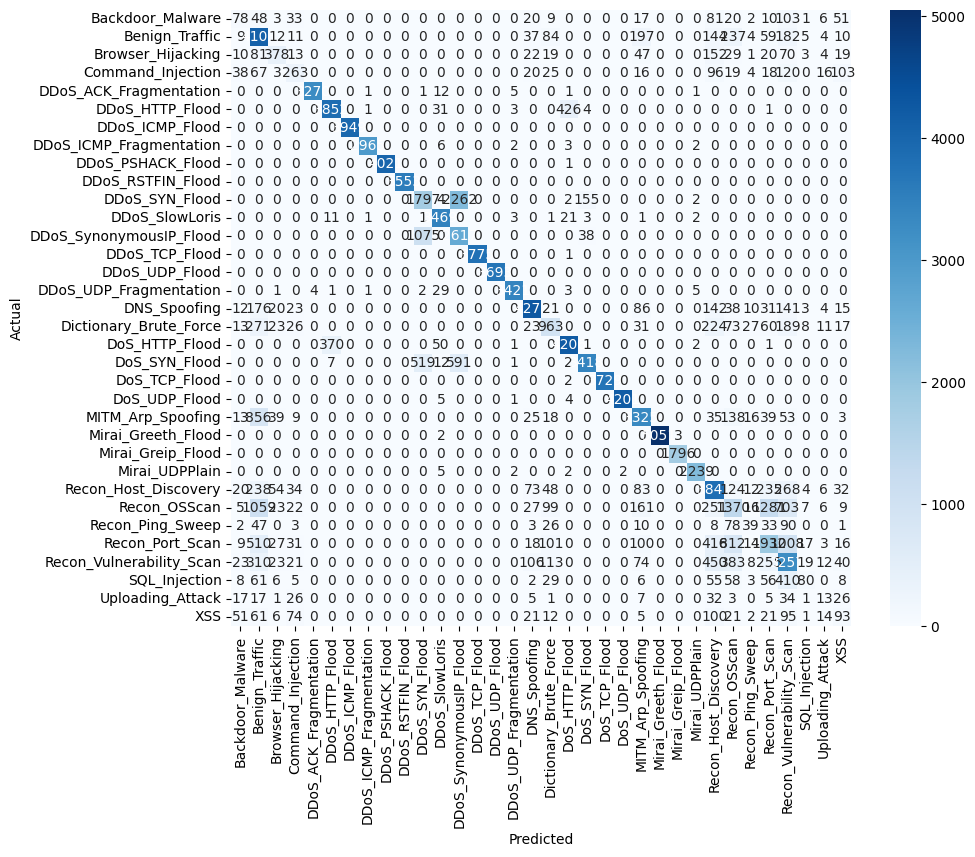

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
class_labels = sorted(set(y_test))

print("\n📊 Confusion Matrix:")
print(pd.DataFrame(cm, index=class_labels, columns=class_labels))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_support = cm.sum(axis=1)

df_class_perf = pd.DataFrame({
    'Class': class_labels,
    'Accuracy': class_accuracy,
    'Support': class_support,
    'Errors': class_support - cm.diagonal()
}).sort_values('Accuracy')

print("\n📉 WORST 10 Classes:")
print(df_class_perf.head(10).to_string(index=False))

print("\n📈 BEST 10 Classes:")
print(df_class_perf.tail(10).to_string(index=False))


📉 WORST 10 Classes:
            Class  Accuracy  Support  Errors
 Uploading_Attack  0.079787      188     173
    SQL_Injection  0.108005      787     702
 Recon_Ping_Sweep  0.111765      340     302
              XSS  0.166378      577     481
 Backdoor_Malware  0.172199      482     399
     Recon_OSScan  0.277634     5039    3640
Command_Injection  0.334158      808     538
  Recon_Port_Scan  0.403470     5014    2991
   DDoS_SYN_Flood  0.414259     4222    2473
Browser_Hijacking  0.456221      868     472

📈 BEST 10 Classes:
             Class  Accuracy  Support  Errors
    Mirai_UDPPlain  0.996000     2250       9
     DoS_UDP_Flood  0.997625     4211      10
Mirai_Greeth_Flood  0.999011     5056       5
     DoS_TCP_Flood  0.999732     3731       1
    DDoS_TCP_Flood  0.999735     3776       1
 DDoS_PSHACK_Flood  1.000000     4022       0
    DDoS_UDP_Flood  1.000000     3693       0
   DDoS_ICMP_Flood  1.000000     3949       0
 Mirai_Greip_Flood  1.000000     1796       0
 DDo

In [ ]:
# Most confused pairs
print("\n⚠️  Most Confused Class Pairs:")
confusion_pairs = []

for i in range(len(class_labels)):
    for j in range(i+1, len(class_labels)):
        total_conf = cm[i, j] + cm[j, i]
        if total_conf > 50:  # Significant confusion
            confusion_pairs.append({
                'Class_A': class_labels[i],
                'Class_B': class_labels[j],
                'Confusion': total_conf
            })

df_confusion = pd.DataFrame(confusion_pairs).sort_values('Confusion', ascending=False)
print(df_confusion.head(10).to_string(index=False))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))


⚠️  Most Confused Class Pairs:
                Class_A                  Class_B  Confusion
         DDoS_SYN_Flood  DDoS_SynonymousIP_Flood       3356
           Recon_OSScan          Recon_Port_Scan       2106
         Benign_Traffic             Recon_OSScan       1295
        Recon_Port_Scan Recon_Vulnerability_Scan       1246
         Benign_Traffic        MITM_Arp_Spoofing       1033
           Recon_OSScan Recon_Vulnerability_Scan       1021
        DDoS_HTTP_Flood           DoS_HTTP_Flood        783
   Recon_Host_Discovery Recon_Vulnerability_Scan        697
DDoS_SynonymousIP_Flood            DoS_SYN_Flood        660
         DDoS_SYN_Flood            DoS_SYN_Flood        628

📊 Classification Report:
                          precision    recall  f1-score   support

        Backdoor_Malware       0.27      0.17      0.21       482
          Benign_Traffic       0.53      0.80      0.64      5098
       Browser_Hijacking       0.64      0.46      0.53       868
       Command_In

### HIERARCHICAL CLASSIFICATION

STEP 1: Define Attack Groups (Domain Expert Knowledge)


In [ ]:
ATTACK_GROUPS = {
    'Benign': [
        'Benign_Traffic'
    ],

    'DDoS': [
        'DDoS_ACK_Fragmentation',
        'DDoS_HTTP_Flood',
        'DDoS_ICMP_Flood',
        'DDoS_ICMP_Fragmentation',
        'DDoS_PSHACK_Flood',
        'DDoS_RSTFIN_Flood',
        'DDoS_SYN_Flood',
        'DDoS_SlowLoris',
        'DDoS_SynonymousIP_Flood',
        'DDoS_TCP_Flood',
        'DDoS_UDP_Flood',
        'DDoS_UDP_Fragmentation'
    ],

    'DoS': [
        'DoS_HTTP_Flood',
        'DoS_SYN_Flood',
        'DoS_TCP_Flood',
        'DoS_UDP_Flood'
    ],

    'Reconnaissance': [
        'Recon_Host_Discovery',
        'Recon_OSScan',
        'Recon_Ping_Sweep',
        'Recon_Port_Scan',
        'Recon_Vulnerability_Scan'
    ],

    'Web_Attack': [
        'SQL_Injection',
        'XSS',
        'Command_Injection',
        'Browser_Hijacking',
        'Uploading_Attack',
        'Backdoor_Malware'
    ],

    'Mirai_Botnet': [
        'Mirai_Greeth_Flood',
        'Mirai_Greip_Flood',
        'Mirai_UDPPlain'
    ],

    'Spoofing': [
        'MITM_Arp_Spoofing',
        'DNS_Spoofing'
    ],

    'Brute_Force': [
        'Dictionary_Brute_Force'
    ]
}

def create_group_mapping():
    """Create mapping from fine-grained label to group label"""
    label_to_group = {}
    group_to_labels = {}

    for group_name, labels in ATTACK_GROUPS.items():
        group_to_labels[group_name] = labels
        for label in labels:
            label_to_group[label] = group_name

    return label_to_group, group_to_labels

def convert_to_groups(y, label_to_group):
    """Convert fine-grained labels to group labels"""
    return np.array([label_to_group.get(label, 'Unknown') for label in y])


STEP 2: Train Hierarchical Classifier

In [ ]:
class HierarchicalClassifier:
    """
    Two-stage hierarchical classifier:
    Stage 1: Classify to 8 groups (high accuracy)
    Stage 2: Within each group, classify to specific attack (if needed)
    """

    def __init__(self, label_to_group, group_to_labels):
        self.label_to_group = label_to_group
        self.group_to_labels = group_to_labels
        self.stage1_model = None  # Group classifier
        self.stage2_models = {}   # Per-group fine classifiers
        self.le_groups = LabelEncoder()
        self.le_fine = {}

    def fit_stage1(self, X_train, y_train_fine, X_val, y_val_fine):
        """Train stage 1: Group classification"""
        print("="*80)
        print("STAGE 1: TRAINING GROUP CLASSIFIER (8 Groups)")
        print("="*80)

        # Convert to groups
        y_train_groups = convert_to_groups(y_train_fine, self.label_to_group)
        y_val_groups = convert_to_groups(y_val_fine, self.label_to_group)

        # Encode
        y_train_encoded = self.le_groups.fit_transform(y_train_groups)
        y_val_encoded = self.le_groups.transform(y_val_groups)

        print(f"\n📊 Group Distribution:")
        for group in self.le_groups.classes_:
            count = np.sum(y_train_groups == group)
            print(f"   {group:20s}: {count:6,} samples")

        # Train LightGBM
        self.stage1_model = lgb.LGBMClassifier(
            n_estimators=500,
            max_depth=20,
            learning_rate=0.1,
            num_leaves=50,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='multiclass',
            num_class=len(self.le_groups.classes_),
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1,
            force_col_wise=True
        )

        print("\n🚀 Training Stage 1 model...")
        self.stage1_model.fit(
            X_train, y_train_encoded,
            eval_set=[(X_val, y_val_encoded)],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
        )

        # Evaluate
        y_val_pred = self.le_groups.inverse_transform(
            self.stage1_model.predict(X_val)
        )

        stage1_acc = accuracy_score(y_val_groups, y_val_pred)
        stage1_f1 = f1_score(y_val_groups, y_val_pred, average='macro')

        print(f"\n✅ Stage 1 Results:")
        print(f"   Validation Accuracy: {stage1_acc:.4f} ({stage1_acc*100:.2f}%)")
        print(f"   Macro F1: {stage1_f1:.4f}")

        return stage1_acc, stage1_f1

    def fit_stage2(self, X_train, y_train_fine, X_val, y_val_fine):
        """Train stage 2: Fine-grained classifiers per group"""
        print("\n" + "="*80)
        print("STAGE 2: TRAINING FINE-GRAINED CLASSIFIERS")
        print("="*80)

        y_train_groups = convert_to_groups(y_train_fine, self.label_to_group)

        for group_name, group_labels in self.group_to_labels.items():
            # Skip if only 1 class in group
            if len(group_labels) == 1:
                print(f"\n⏭️  {group_name}: Only 1 class, skipping fine classifier")
                continue

            print(f"\n📋 Training {group_name} classifier...")

            # Get samples for this group
            train_mask = np.array([label in group_labels for label in y_train_fine])

            if train_mask.sum() == 0:
                print(f"   ⚠️  No training samples for {group_name}")
                continue

            X_train_group = X_train[train_mask]
            y_train_group = y_train_fine[train_mask]

            # Encode labels
            le_group = LabelEncoder()
            y_train_encoded = le_group.fit_transform(y_train_group)
            self.le_fine[group_name] = le_group

            print(f"   Classes: {len(le_group.classes_)}")
            print(f"   Samples: {len(X_train_group):,}")

            # Train model
            model = lgb.LGBMClassifier(
                n_estimators=300,
                max_depth=15,
                learning_rate=0.1,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='multiclass',
                num_class=len(le_group.classes_),
                class_weight='balanced',
                random_state=42,
                n_jobs=-1,
                verbose=-1,
                force_col_wise=True
            )

            model.fit(X_train_group, y_train_encoded)
            self.stage2_models[group_name] = model

            print(f"   ✅ {group_name} classifier trained")

    def predict(self, X):
        """Hierarchical prediction: Stage 1 → Stage 2"""
        # Stage 1: Predict groups
        groups_pred_encoded = self.stage1_model.predict(X)
        groups_pred = self.le_groups.inverse_transform(groups_pred_encoded)

        # Stage 2: Predict fine-grained within each group
        predictions = []

        for i in range(len(X)):
            group = groups_pred[i]

            # If group has only 1 class, return that class
            if len(self.group_to_labels[group]) == 1:
                predictions.append(self.group_to_labels[group][0])

            # If no fine classifier trained, return first class in group
            elif group not in self.stage2_models:
                predictions.append(self.group_to_labels[group][0])

            # Use fine classifier
            else:
                X_sample = X[i:i+1]
                fine_pred_encoded = self.stage2_models[group].predict(X_sample)
                fine_pred = self.le_fine[group].inverse_transform(fine_pred_encoded)
                predictions.append(fine_pred[0])

        return np.array(predictions)

    def evaluate(self, X_test, y_test_fine, print_report=True):
        """Evaluate both stages"""
        print("\n" + "="*80)
        print("HIERARCHICAL EVALUATION")
        print("="*80)

        # Stage 1 evaluation
        y_test_groups = convert_to_groups(y_test_fine, self.label_to_group)
        groups_pred_encoded = self.stage1_model.predict(X_test)
        groups_pred = self.le_groups.inverse_transform(groups_pred_encoded)

        stage1_acc = accuracy_score(y_test_groups, groups_pred)
        stage1_f1 = f1_score(y_test_groups, groups_pred, average='macro')

        print(f"\n📊 STAGE 1 (Group Classification):")
        print(f"   Test Accuracy: {stage1_acc:.4f} ({stage1_acc*100:.2f}%)")
        print(f"   Macro F1: {stage1_f1:.4f}")

        if print_report:
            print("\n   Classification Report:")
            print(classification_report(y_test_groups, groups_pred, zero_division=0))

        # Stage 2 evaluation (full pipeline)
        y_pred_fine = self.predict(X_test)

        stage2_acc = accuracy_score(y_test_fine, y_pred_fine)
        stage2_f1 = f1_score(y_test_fine, y_pred_fine, average='macro')

        print(f"\n📊 STAGE 2 (Fine-Grained Classification):")
        print(f"   Test Accuracy: {stage2_acc:.4f} ({stage2_acc*100:.2f}%)")
        print(f"   Macro F1: {stage2_f1:.4f}")

        if print_report:
            print("\n   Classification Report:")
            print(classification_report(y_test_fine, y_pred_fine, zero_division=0))

        return {
            'stage1_accuracy': stage1_acc,
            'stage1_f1': stage1_f1,
            'stage2_accuracy': stage2_acc,
            'stage2_f1': stage2_f1,
            'groups_pred': groups_pred,
            'fine_pred': y_pred_fine
        }

STEP 3: Visualization

In [ ]:
def plot_group_confusion_matrix(y_true_groups, y_pred_groups, save_path='group_cm.png'):
    """Plot confusion matrix for group classification"""
    cm = confusion_matrix(y_true_groups, y_pred_groups)
    group_labels = sorted(set(y_true_groups))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=group_labels, yticklabels=group_labels)
    plt.title('Confusion Matrix - Group Classification (Stage 1)',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Group', fontsize=12)
    plt.xlabel('Predicted Group', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Group confusion matrix saved: {save_path}")
    plt.show()

def compare_approaches(results_dict):
    """Compare different approaches"""
    print("\n" + "="*80)
    print("📊 APPROACH COMPARISON")
    print("="*80)

    df_comparison = pd.DataFrame(results_dict).T
    df_comparison = df_comparison.sort_values('Test_Accuracy', ascending=False)

    print("\n" + df_comparison.to_string())

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(df_comparison))
    ax.bar(x, df_comparison['Test_Accuracy'], color='steelblue', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(df_comparison.index, rotation=45, ha='right')
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Model Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, v in enumerate(df_comparison['Test_Accuracy']):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('approach_comparison.png', dpi=150, bbox_inches='tight')
    print("\n💾 Comparison plot saved: approach_comparison.png")
    plt.show()


MAIN EXECUTION

🚀 HIERARCHICAL CLASSIFICATION PIPELINE

📋 Attack Group Structure:

Benign:
   • Benign_Traffic

DDoS:
   • DDoS_ACK_Fragmentation
   • DDoS_HTTP_Flood
   • DDoS_ICMP_Flood
   • DDoS_ICMP_Fragmentation
   • DDoS_PSHACK_Flood
   • DDoS_RSTFIN_Flood
   • DDoS_SYN_Flood
   • DDoS_SlowLoris
   • DDoS_SynonymousIP_Flood
   • DDoS_TCP_Flood
   • DDoS_UDP_Flood
   • DDoS_UDP_Fragmentation

DoS:
   • DoS_HTTP_Flood
   • DoS_SYN_Flood
   • DoS_TCP_Flood
   • DoS_UDP_Flood

Reconnaissance:
   • Recon_Host_Discovery
   • Recon_OSScan
   • Recon_Ping_Sweep
   • Recon_Port_Scan
   • Recon_Vulnerability_Scan

Web_Attack:
   • SQL_Injection
   • XSS
   • Command_Injection
   • Browser_Hijacking
   • Uploading_Attack
   • Backdoor_Malware

Mirai_Botnet:
   • Mirai_Greeth_Flood
   • Mirai_Greip_Flood
   • Mirai_UDPPlain

Spoofing:
   • MITM_Arp_Spoofing
   • DNS_Spoofing

Brute_Force:
   • Dictionary_Brute_Force
STAGE 1: TRAINING GROUP CLASSIFIER (8 Groups)

📊 Group Distribution:
   Benign              

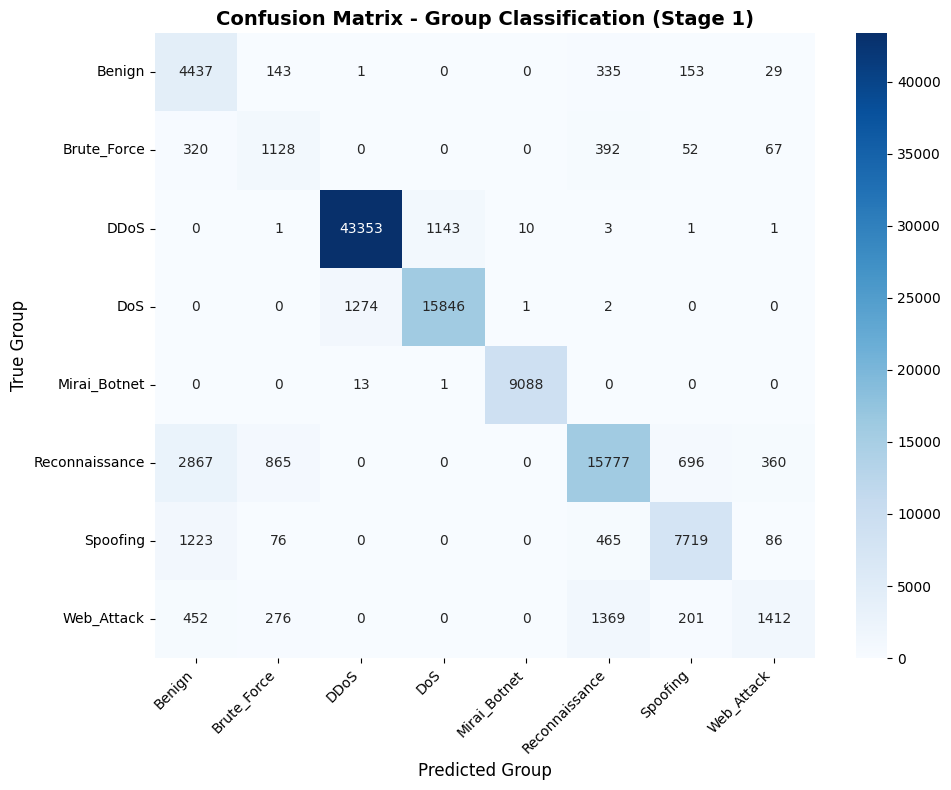


💾 Model saved: hierarchical_classifier.pkl


In [ ]:
def run_hierarchical_classification(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Complete pipeline untuk hierarchical classification
    """
    print("🚀 HIERARCHICAL CLASSIFICATION PIPELINE")
    print("="*80)

    # Create mappings
    label_to_group, group_to_labels = create_group_mapping()

    print(f"\n📋 Attack Group Structure:")
    for group_name, labels in group_to_labels.items():
        print(f"\n{group_name}:")
        for label in labels:
            print(f"   • {label}")

    # Initialize classifier
    hierarchical_clf = HierarchicalClassifier(label_to_group, group_to_labels)

    # Train Stage 1
    stage1_acc, stage1_f1 = hierarchical_clf.fit_stage1(
        X_train, y_train, X_val, y_val
    )

    # Train Stage 2
    hierarchical_clf.fit_stage2(X_train, y_train, X_val, y_val)

    # Evaluate
    results = hierarchical_clf.evaluate(X_test, y_test, print_report=True)

    # Plot group confusion matrix
    y_test_groups = convert_to_groups(y_test, label_to_group)
    plot_group_confusion_matrix(y_test_groups, results['groups_pred'])

    # Save model
    import joblib
    joblib.dump(hierarchical_clf, 'hierarchical_classifier.pkl')
    print("\n💾 Model saved: hierarchical_classifier.pkl")

    return hierarchical_clf, results

# Run the pipeline
hierarchical_classifier, hierarchical_results = run_hierarchical_classification(
    X_train, y_train, X_val, y_val, X_test, y_test
)


📊 APPROACH COMPARISON

                            Test_Accuracy  Macro_F1
Hierarchical_Stage1_Groups       0.884645  0.771588
Flat_34_Classes                  0.800700  0.713700
Hierarchical_Stage2_Full         0.793574  0.703033

💾 Comparison plot saved: approach_comparison.png


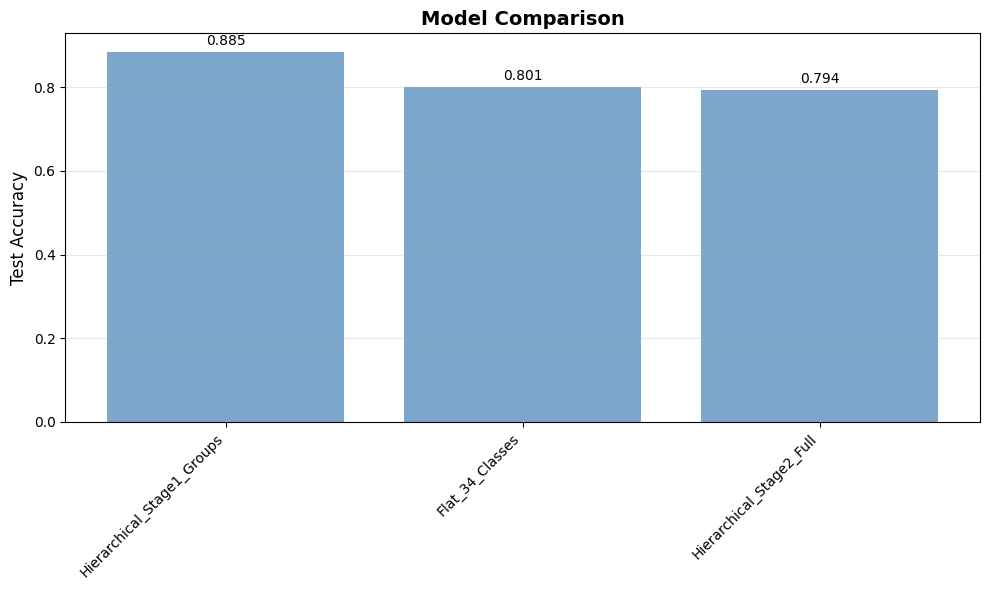

In [ ]:
# ============================================
# SECTION 6: FINAL COMPARISON
# ============================================
comparison = {
    'Flat_34_Classes': {
        'Test_Accuracy': 0.8007,
        'Macro_F1': 0.7137
    },
    'Hierarchical_Stage1_Groups': {
        'Test_Accuracy': hierarchical_results['stage1_accuracy'],
        'Macro_F1': hierarchical_results['stage1_f1']
    },
    'Hierarchical_Stage2_Full': {
        'Test_Accuracy': hierarchical_results['stage2_accuracy'],
        'Macro_F1': hierarchical_results['stage2_f1']
    }
}

compare_approaches(comparison)